# **Brief Analysis of Regent Street Energy Efficiency**

## **Datasets**
### *Energy Efficiency Data*
**Source:** Department of Leveling Up, Housing and Communities  
**Link:** [EPC Open Data](https://epc.opendatacommunities.org/)  
**Documentation:** [EPC Data Documentation](https://epc.opendatacommunities.org/docs/guidance#field_domestic_CURRENT_ENERGY_EFFICIENCY)  
*Note: Domestic files provide energy costs, but Non-Domestic data isn't provided.*

### *Geospatial Data from Postcode Shapefile*
**Source:** Ordnance Survey  
**Link:** [Code-Point Postcodes with Points](https://www.ordnancesurvey.co.uk/products/code-point-polygons)  
*Note: The free data is from the sample on this website, which includes POINT data for postcodes.*

## **High Level Research Questions**
1. How does Regent Street's energy efficiency and savings potential compare to other nearby neighborhoods?
2. What is the total energy savings potential of the assets on Regent Street?
3. Which potential assets on Regent Street are worth flagging for potential savings?


In [1]:
# load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import geopandas as gpd
import folium
from folium import Marker
from folium import Circle
from shapely.geometry import Point


In [2]:
# load data
domestic_westminster = pd.read_csv('regent_street_analysis/domestic_westminster.csv')
non_domestic_regent = pd.read_csv('regent_street_analysis/non_domestic_regent.csv')

/tmp/ipykernel_29231/4238117304.py:3: DtypeWarning: Columns (15,37) have mixed types. Specify dtype option on import or set low_memory=False.
  domestic_westminster = pd.read_csv('/workspaces/spectacle-eng-pipeline/domestic_westminster.csv')


### Clean Data

In [3]:
def clean(df):
    '''Return clean energy ratings data'''
    
    df.columns = df.columns.str.lower()
    
    # Convert 'date_column' to datetime and extract the year
    df['inspection_date'] = pd.to_datetime(df['inspection_date'])
    df['inspection_year'] = df['inspection_date'].dt.year

    return df

In [4]:
# clean domestic westminster and non-domestic Regent St
domestic_westminster = clean(domestic_westminster)
non_domestic_regent = clean(non_domestic_regent)

# **Explore the Data**

## **High-level Questions**
- **(1)** Are the number of properties being inspected and recorded increasing?
- **(2)** As a percentage of the properties inspected, is the share for each energy rating changing?


##### (1) Are the number of properties being inspected and recorded increasing?

In [6]:
def total_inspections(df):
    '''Returns dataframe with total inspections over time'''

    # groupby year and count number of rows
    total_inspections = pd.DataFrame(
        df.groupby('inspection_year')['current_energy_rating'].count()
        ).rename(
        columns={'current_energy_rating' : 'current_energy_rating_count'},
    )

    # convert index to datetime
    total_inspections.index = pd.to_datetime(total_inspections.index, format='%Y')
    
    return total_inspections

In [7]:
# calculate total inspections for domestic properties in westminster over time
total_inspections = total_inspections(domestic_westminster)

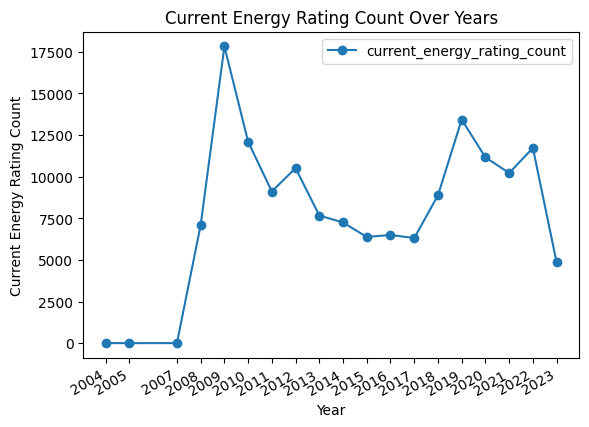

In [8]:
# plot line chart of inspections
total_inspections.plot(kind='line', y='current_energy_rating_count', marker='o')
plt.xlabel('Year')
plt.ylabel('Current Energy Rating Count')
plt.title('Current Energy Rating Count Over Years')
# Set the x-axis ticks to be the datetime index with year format
plt.xticks(total_inspections.index, total_inspections.index.strftime('%Y'))

plt.show()

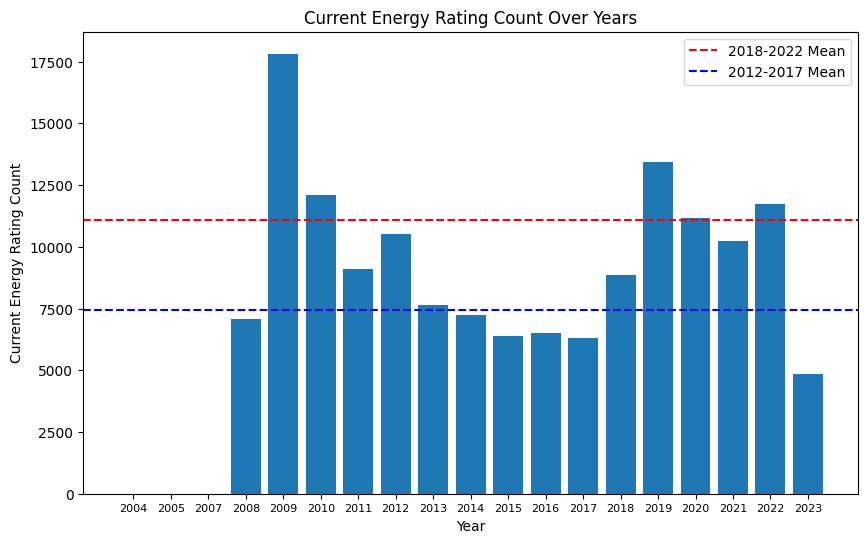

In [9]:
# turn into string otherwise will get 2018.5
total_inspections.index = total_inspections.index.year.astype(str)

# group data by year and calculate the mean averages for the two periods
mean_2018_2022 = total_inspections['current_energy_rating_count'].loc['2018':'2022'].mean()
mean_2012_2017 = total_inspections['current_energy_rating_count'].loc['2012':'2017'].mean()

data = list(total_inspections['current_energy_rating_count'])
bars = list(total_inspections.index)

plt.figure(figsize=(10, 6))
plt.bar(bars, data)
plt.xticks(bars, fontsize=8)
# Add dashed lines for the mean averages
plt.axhline(mean_2018_2022, color='r', linestyle='--', label='2018-2022 Mean')
plt.axhline(mean_2012_2017, color='b', linestyle='--', label='2012-2017 Mean')
plt.xlabel('Year')
plt.ylabel('Current Energy Rating Count')
plt.title('Current Energy Rating Count Over Years')
plt.legend()

plt.show()

# It's interesting how it spikes in 2009 and then moderates to 2008 levels
# Answer to Question (1) is yes, 2018-2022 average is higher than 2008-2017 average
# Notice it might be better to work with 2022 data than 2023 due to amount recorded
# Perhaps not all properties for 2023 have been recorded yet



##### (2) As a % of the properties inspected, is the share for each energy rating changing?

In [10]:
def energy_rating_share(df):
    '''Returns the share of energy ratings df over time'''

    # groupby inspection year and energy rating and sum
    df = pd.DataFrame(df.groupby(['inspection_year', 'current_energy_rating'])['total_floor_area'].sum())
    df = df.pivot_table(index='inspection_year', columns='current_energy_rating', fill_value=0)
    df = df.droplevel(level=0, axis=1)

    # calculate proportions from total
    df['sum'] = df.sum(axis=1)
    df['A'] = df['A'].div(df['sum'])
    df['B'] = df['B'].div(df['sum'])
    df['C'] = df['C'].div(df['sum'])
    df['D'] = df['D'].div(df['sum'])
    df['E'] = df['E'].div(df['sum'])
    df['F'] = df['F'].div(df['sum'])
    df['G'] = df['G'].div(df['sum'])
    df = df.drop(columns=['sum'])

    return df

In [11]:
energy_rating_share = energy_rating_share(domestic_westminster)

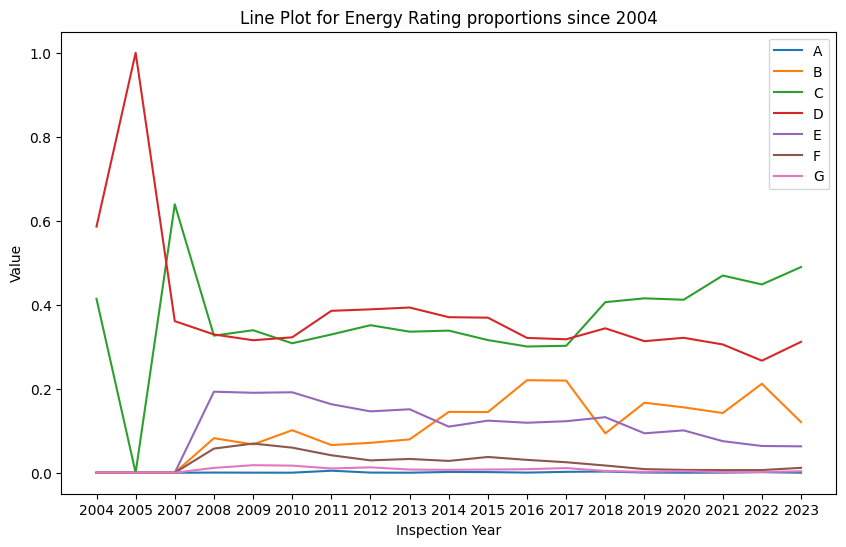

In [12]:
# Create a line plot

# format year otherwise will produce 2018.5
energy_rating_share.index = pd.to_datetime(
    energy_rating_share.index, 
    format='%Y').year.astype(str)

# plot
plt.figure(figsize=(10, 6))
for column in energy_rating_share.columns:
    plt.plot(energy_rating_share.index, energy_rating_share[column], label=column)
plt.xlabel('Inspection Year')
plt.ylabel('Value')
plt.title('Line Plot for Energy Rating proportions since 2004')
plt.legend()
plt.show()

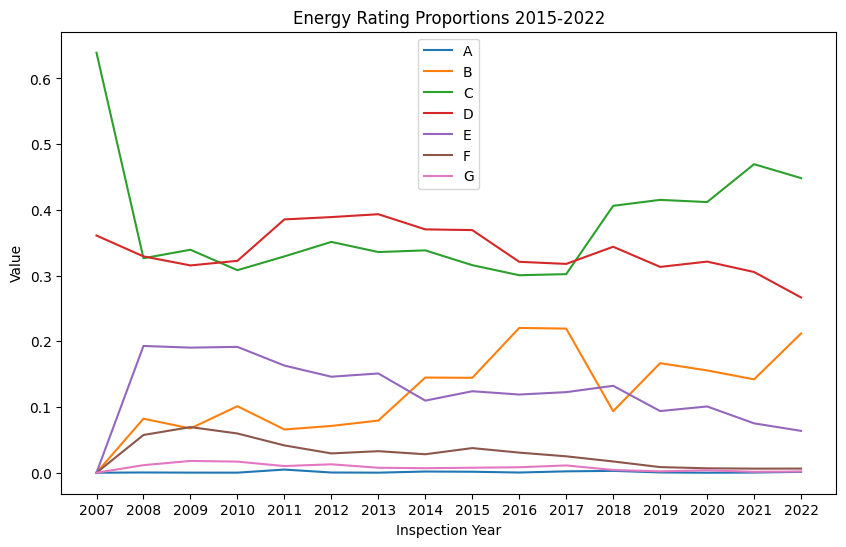

In [13]:
# filter for 2015-2022
filtered_energy_rating_share = energy_rating_share.copy()
filtered_energy_rating_share.index = filtered_energy_rating_share.index.astype(int)
filtered_energy_rating_share = filtered_energy_rating_share[
    (filtered_energy_rating_share.index >=2007) 
    & (filtered_energy_rating_share.index <=2022)
]

# format year otherwise will produce 2018.5
filtered_energy_rating_share.index = pd.to_datetime(
    filtered_energy_rating_share.index, 
    format='%Y').year.astype(str)

# plot
plt.figure(figsize=(10, 6))
for column in filtered_energy_rating_share.columns:
    plt.plot(filtered_energy_rating_share.index, filtered_energy_rating_share[column], label=column)
plt.xlabel('Inspection Year')
plt.ylabel('Value')
plt.title('Energy Rating Proportions 2015-2022')
plt.legend()
plt.show()

# Create a line plot
# Looks like A isn't moving much
# Looks like B and C are increasing in proportion
# Lokks like D, E, F and G is decreasing

## **Regent Street Surroundings Analysis**

- **(1)** What is the difference in energy efficiency across energy bands
- **(2)** What is the relative energy efficiency of Regent Street compared to other streets in Westminster


In [15]:
# ordanance survey shapefile
postcodes = gpd.read_file('/workspaces/spectacle-eng-pipeline/Code-Point London (shapefile)/CodePointOpen_London_201709.shp')

In [16]:
def clean_postcodes(df):
    '''Returns correct format and Long Lat'''

    # define the UTM projection (EPSG:32630)
    utm_projection = '+proj=utm +zone=30 +datum=WGS84 +units=m +no_defs'

    # convert the "geometry" column to a Shapely geometry column
    df['geometry'] = df['geometry'].apply(Point)

    # project the geometries from EPSG:32630 to EPSG:4326 (WGS84)
    df = df.to_crs(epsg=4326)

    # create new columns for latitude and longitude
    df['Lat'] = df['geometry'].y
    df['Long'] = df['geometry'].x

    return df[['postcode','Lat', 'Long', 'geometry']]


In [17]:
clean_postcodes = clean_postcodes(postcodes)

In [18]:
# energy_savings function

def average_energy_costs_savings_per_m2(df):
    '''Returns the average lighting cost and savings per m2 for 2022'''

    # clean and create year column
    df.columns = df.columns.str.lower()
    df['inspection_date'] = pd.to_datetime(df['inspection_date'])
    df['year'] = df['inspection_date'].dt.year

    # filter for 2022 and columns
    df = df[df['year'] == 2022]
    df = df[['current_energy_rating', 
             'lighting_cost_current', 
             'heating_cost_current',
             'lighting_cost_potential',
             'heating_cost_potential',
             'total_floor_area']]
    
    # clean data as division by zero is inf
    df = df[df['total_floor_area'] != 0]

    df['lighting_savings_potential'] = df['lighting_cost_current'] - df['lighting_cost_potential']
    df['heating_savings_potential'] = df['heating_cost_current'] - df['heating_cost_potential']


    df['lighting_cost_per_m2'] = df['lighting_cost_current'].div(df['total_floor_area'])
    df['heating_cost_per_m2'] = df['heating_cost_current'].div(df['total_floor_area'])
    df['lighting_savings_per_m2'] = df['lighting_savings_potential'].div(df['total_floor_area'])
    df['heating_savings_per_m2'] = df['heating_savings_potential'].div(df['total_floor_area'])
    
    df = pd.DataFrame(
        df.groupby('current_energy_rating')['lighting_cost_per_m2', 
                                            'heating_cost_per_m2',
                                            'lighting_savings_per_m2',
                                            'heating_savings_per_m2'].mean()
    )

    return df
    

In [19]:
df = average_energy_costs_savings_per_m2(domestic_westminster)
df

/tmp/ipykernel_29231/248363956.py:33: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('current_energy_rating')['lighting_cost_per_m2',


lighting_cost_per_m2  heating_cost_per_m2  \
current_energy_rating                                              
A                                  0.773499             2.172656   
B                                  0.902891             2.328278   
C                                  1.040616             5.284616   
D                                  1.052218             8.577507   
E                                  1.060085            14.431562   
F                                  1.074956            22.847792   
G                                  0.990750            32.861298   

                       lighting_savings_per_m2  heating_savings_per_m2  
current_energy_rating                                                   
A                                     0.000000                0.000000  
B                                     0.026412                0.026661  
C                                     0.092143                1.437883  
D                                     0.129100                3.575949  
E                                     0.119580                8.358136  
F                                     0.090471               14.186231  
G                                     0.043795               22.041782

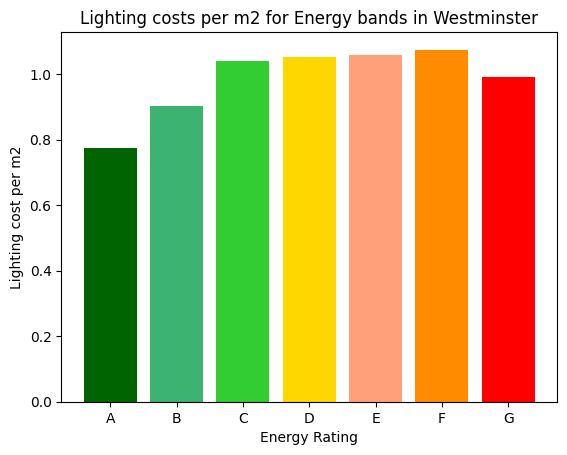

In [20]:
# Plotting average lighting costs per m2

light_data = list(df['lighting_cost_per_m2'])
light_bars = list(df.index)
plt.bar(light_bars, light_data, color=['darkgreen', 'mediumseagreen', 'limegreen', 'gold', 'lightsalmon', 'darkorange', 'red'])
plt.xticks(light_bars)
plt.xlabel('Energy Rating')
plt.ylabel('Lighting cost per m2')
plt.title('Lighting costs per m2 for Energy bands in Westminster')

plt.show()

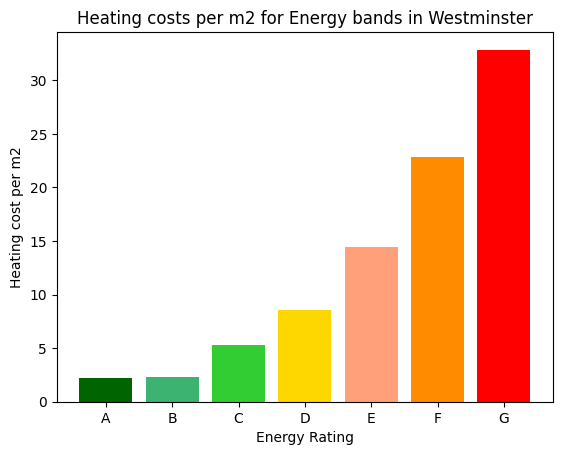

In [21]:
# Plotting average Heating costs per m2

heat_data = list(df['heating_cost_per_m2'])
heat_bars = list(df.index)
plt.bar(heat_bars, heat_data, color=['darkgreen', 'mediumseagreen', 'limegreen', 'gold', 'lightsalmon', 'darkorange', 'red'])
plt.xticks(heat_bars)
plt.xlabel('Energy Rating')
plt.ylabel('Heating cost per m2')
plt.title('Heating costs per m2 for Energy bands in Westminster')

plt.show()

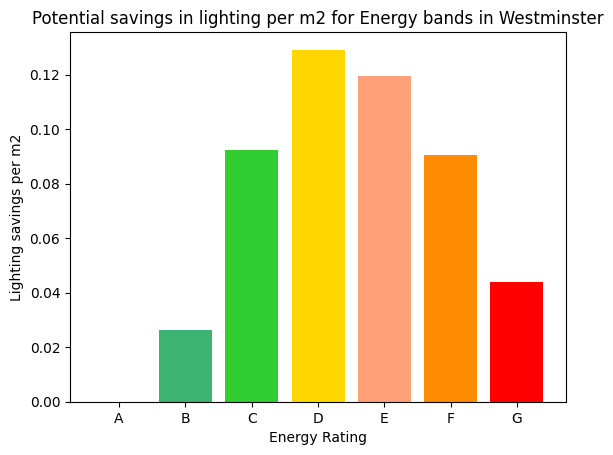

In [22]:
# Plotting average lighting costs per m2

light_savings_data = list(df['lighting_savings_per_m2'])
light_savings_bars = list(df.index)
plt.bar(light_savings_bars, light_savings_data, color=['darkgreen', 'mediumseagreen', 'limegreen', 'gold', 'lightsalmon', 'darkorange', 'red'])
plt.xticks(light_savings_bars)
plt.xlabel('Energy Rating')
plt.ylabel('Lighting savings per m2')
plt.title('Potential savings in lighting per m2 for Energy bands in Westminster')

plt.show()

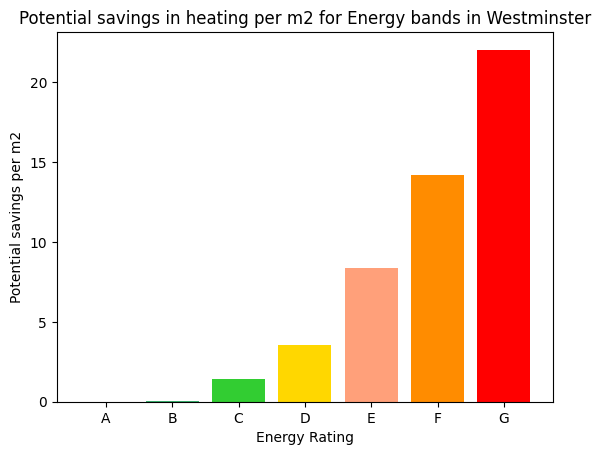

In [23]:
# Plotting average Heating costs per m2

heat_savings_data = list(df['heating_savings_per_m2'])
heat_savings_bars = list(df.index)
plt.bar(heat_savings_bars, heat_savings_data, color=['darkgreen', 'mediumseagreen', 'limegreen', 'gold', 'lightsalmon', 'darkorange', 'red'])
plt.xticks(heat_savings_bars)
plt.xlabel('Energy Rating')
plt.ylabel('Potential savings per m2')
plt.title('Potential savings in heating per m2 for Energy bands in Westminster')

plt.show()

In [24]:
def savings_by_postcode(df):
    '''Returns the average lighting cost per m2 for 2022'''

    # clean and create year column
    df.columns = df.columns.str.lower()
    df['inspection_date'] = pd.to_datetime(df['inspection_date'])
    df['year'] = df['inspection_date'].dt.year

    # filter for 2022 and columns
    df = df[df['year'] == 2022]
    df = df[['postcode',
             'current_energy_rating', 
             'lighting_cost_current', 
             'heating_cost_current',
             'lighting_cost_potential',
             'heating_cost_potential',
             'total_floor_area',
    ]]

    df['lighting_savings_potential'] = df['lighting_cost_current'] - df['lighting_cost_potential']
    df['heating_savings_potential'] = df['heating_cost_current'] - df['heating_cost_potential']
    df['energy_savings_potential'] = df['lighting_savings_potential'] + df['heating_savings_potential']

    df = df.groupby('postcode')[['lighting_savings_potential', 
                                'heating_savings_potential', 
                                'energy_savings_potential',
                                'total_floor_area']].sum()
    
    # create savings per m2
    df['energy_savings_potential_per_m2'] = df['energy_savings_potential'].div(df['total_floor_area'])
    
    # no savings should have negative values
    df = df.applymap(lambda x: 0 if x < 0 else x)
    

    return df.reset_index()

In [25]:
savings_by_postcode = savings_by_postcode(domestic_westminster)
savings_by_postcode

postcode  lighting_savings_potential  heating_savings_potential  \
0      NW1 4PJ                        25.0                      791.0   
1      NW1 4PR                         0.0                      530.0   
2      NW1 4PS                         0.0                      679.0   
3      NW1 4QA                       191.0                     1846.0   
4      NW1 4QB                         0.0                      244.0   
...        ...                         ...                        ...   
3476  WC2R 0EY                        96.0                       38.0   
3477  WC2R 0NP                        33.0                       85.0   
3478  WC2R 0PP                         0.0                        0.0   
3479  WC2R 1BE                         0.0                        0.0   
3480  WC2R 1HA                      1134.0                     1736.0   

      energy_savings_potential  total_floor_area  \
0                        816.0             409.0   
1                        530.0             225.0   
2                        676.0             331.0   
3                       2037.0             537.0   
4                        244.0             177.0   
...                        ...               ...   
3476                     134.0             120.0   
3477                     118.0             390.0   
3478                       0.0             131.0   
3479                       0.0             101.0   
3480                    2870.0            4235.0   

      energy_savings_potential_per_m2  
0                            1.995110  
1                            2.355556  
2                            2.042296  
3                            3.793296  
4                            1.378531  
...                               ...  
3476                         1.116667  
3477                         0.302564  
3478                         0.000000  
3479                         0.000000  
3480                         0.677686  

[3481 rows x 6 columns]

In [26]:
def savings_geospatial(savings_by_postcode, clean_postcodes):
    clean_postcodes = clean_postcodes[['postcode', 'geometry', 'Lat', 'Long']]

    # clean both postcode columns
    savings_by_postcode['postcode'] = savings_by_postcode['postcode'].astype(str)
    clean_postcodes['postcode'] = clean_postcodes['postcode'].astype(str)
    
    savings_by_postcode['postcode'] = savings_by_postcode['postcode'].str.lower().str.replace(' ', '')
    clean_postcodes.loc[:,'postcode'] = clean_postcodes['postcode'].str.lower().str.replace(' ', '')

    # merge
    savings_geospatial = clean_postcodes.merge(savings_by_postcode, on='postcode', how='left')
    savings_geospatial = savings_geospatial.dropna()
    
    return savings_geospatial

In [27]:
savings_geospatial = savings_geospatial(savings_by_postcode, clean_postcodes)
savings_geospatial.head()

postcode                   geometry        Lat      Long  \
79182   nw14pj  POINT (-0.14905 51.52449)  51.524489 -0.149050   
79185   nw14pr  POINT (-0.14946 51.52358)  51.523579 -0.149462   
79186   nw14ps  POINT (-0.14959 51.52406)  51.524057 -0.149587   
79192   nw14qa  POINT (-0.15428 51.52352)  51.523520 -0.154279   
79193   nw14qb  POINT (-0.15361 51.52319)  51.523195 -0.153615   

       lighting_savings_potential  heating_savings_potential  \
79182                        25.0                      791.0   
79185                         0.0                      530.0   
79186                         0.0                      679.0   
79192                       191.0                     1846.0   
79193                         0.0                      244.0   

       energy_savings_potential  total_floor_area  \
79182                     816.0             409.0   
79185                     530.0             225.0   
79186                     676.0             331.0   
79192                    2037.0             537.0   
79193                     244.0             177.0   

       energy_savings_potential_per_m2  
79182                         1.995110  
79185                         2.355556  
79186                         2.042296  
79192                         3.793296  
79193                         1.378531

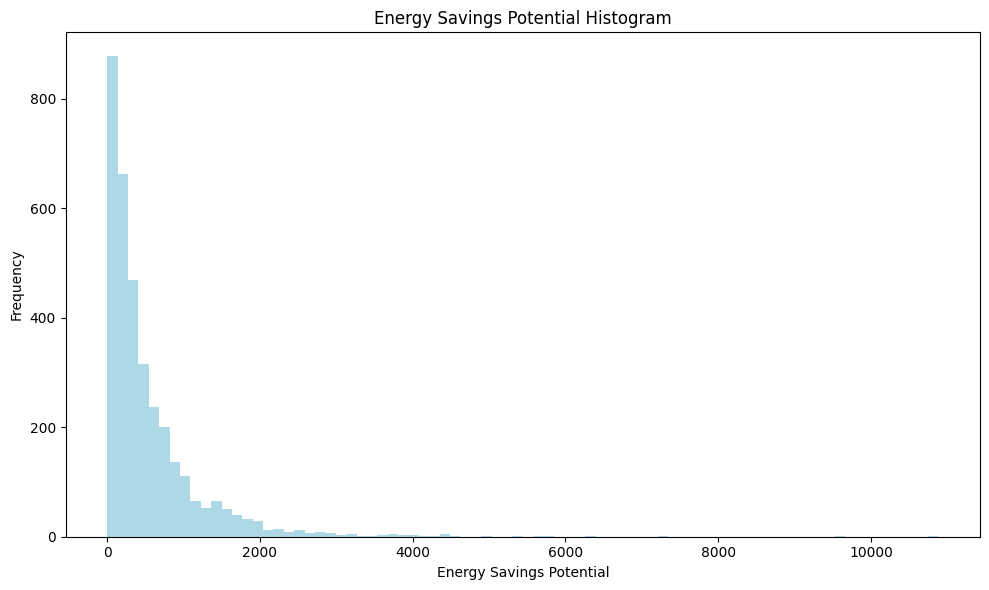

In [28]:
# Extract the data from the column
energy_savings_per_m2 = savings_geospatial['energy_savings_potential']

# Create the histogram
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(energy_savings_per_m2, bins=80, color='lightblue')  # Assuming you want to use 'mediumseagreen' color
plt.xlabel('Energy Savings Potential')  # Replace with the appropriate x-axis label
plt.ylabel('Frequency')  # Replace with the appropriate y-axis label
plt.title('Energy Savings Potential Histogram')  # Replace with the appropriate title

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

In [29]:
# Extract the data from the column
energy_savings = savings_geospatial['energy_savings_potential']

# Calculate the septiles
septiles = np.percentile(energy_savings, [14.2857, 28.5714, 42.8571, 57.1429, 71.4286, 85.7143])

print("Septiles:")
for i, septile in enumerate(septiles, start=1):
    print(f"Septile {i}: {septile}")

Septiles:
Septile 1: 67.0
Septile 2: 155.0
Septile 3: 256.0
Septile 4: 398.0
Septile 5: 621.0
Septile 6: 1029.1433499999998


In [30]:
# Creating a map with absolute savings
# Note this is not standardized for m2

def color_producer_abs(val):
   '''Returns a colour for value range'''
   if val < 200:
      return '#FFB6C1' # '#FFB6C1' (Light Pink)
   elif val < 400:
      return '#FFC0CB' # '#FFC0CB' (Pink)
   elif val < 600:
      return '#FF69B4' # '#FF69B4' (Hot Pink)
   elif val < 800:
      return '#FF1493' # '#FF1493' (Deep Pink)
   elif val < 1000:
      return '#C71585' # '#C71585' (Medium Violet Red)
   elif val < 1500:
      return '#DB7093' # '#DB7093' (Pale Violet Red)
   else:
      return '#8B0000' # '#8B0000' (Dark Red)

# creates Westminster map
m = folium.Map(location=[51.52,-0.15], tiles='cartodbpositron', zoom_start=13)

# plots a marker circle using assigned colours
for i in range(0, len(savings_geospatial)):
    color = color_producer_abs(savings_geospatial.iloc[i]['energy_savings_potential'])
    Circle(
        location=[savings_geospatial.iloc[i]['Lat'], savings_geospatial.iloc[i]['Long']],
        radius=20,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        weight=1,
    ).add_to(m)
m

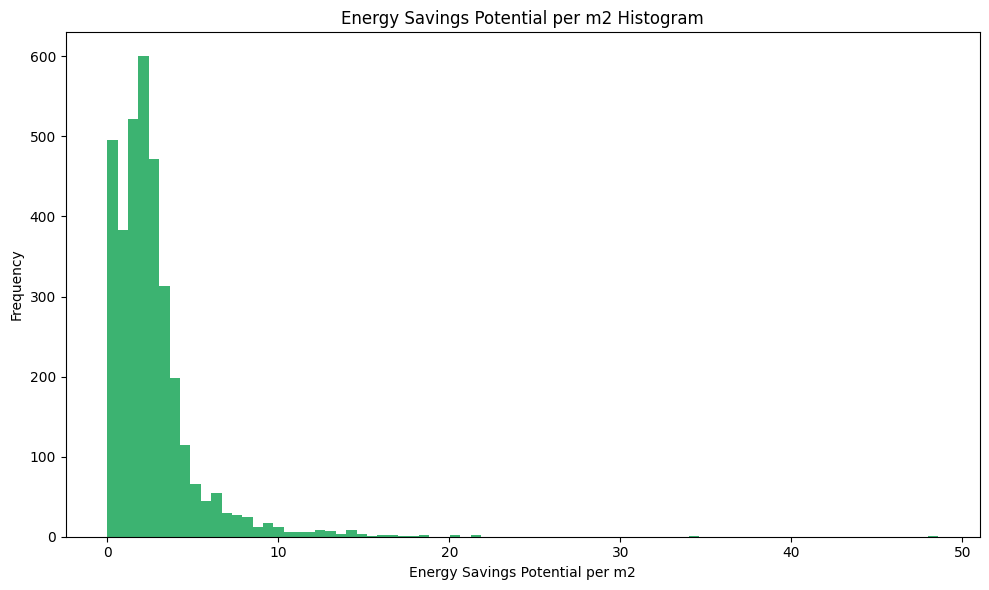

In [31]:
# Extract the data from the column
energy_savings_per_m2 = savings_geospatial['energy_savings_potential_per_m2']

# Create the histogram
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(energy_savings_per_m2, bins=80, color='mediumseagreen')  # Assuming you want to use 'mediumseagreen' color
plt.xlabel('Energy Savings Potential per m2')  # Replace with the appropriate x-axis label
plt.ylabel('Frequency')  # Replace with the appropriate y-axis label
plt.title('Energy Savings Potential per m2 Histogram')  # Replace with the appropriate title

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()


In [32]:

# Calculate the septiles
septiles = np.percentile(energy_savings_per_m2, [14.2857, 28.5714, 42.8571, 57.1429, 71.4286, 85.7143])

print("Septiles:")
for i, septile in enumerate(septiles, start=1):
    print(f"Septile {i}: {septile}")

Septiles:
Septile 1: 0.6013651792828686
Septile 2: 1.358652486772487
Septile 3: 1.9014502001194744
Septile 4: 2.3962219682943764
Septile 5: 3.0281643743257822
Septile 6: 4.154345176051293


In [33]:
# creating a map for savings per m2

m_2 = folium.Map(location=[51.52,-0.15], tiles='cartodbpositron', zoom_start=13)
def color_producer_m2(val):
    '''Retruns a colour for the value range'''
    if val < 0.8:
        return '#ADD8E6'
    elif val < 1.6:
        return '#87CEEB'
    elif val < 2.4:
        return '#00BFFF'
    elif val < 3.2:
        return '#1E90FF'
    elif val < 4.0:
        return '#4169E1'
    elif val < 4.8:
        return '#0000CD'
    else:
        return '#00008B'

for i in range(0, len(savings_geospatial)):
    color = color_producer_m2(savings_geospatial.iloc[i]['energy_savings_potential_per_m2'])
    Circle(
        location=[savings_geospatial.iloc[i]['Lat'], savings_geospatial.iloc[i]['Long']],
        radius=20,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        weight=1,
    ).add_to(m_2)
m_2

# Analysis of Regent Street

- **(1)** In terms of decarbonising the regent's street portfolio, where could you get the most savings per m2?
- **(2)** Where are the largest savings if one postcode is considered as a unique retrofit project?

In [34]:
savings_geospatial

postcode                   geometry        Lat      Long  \
79182    nw14pj  POINT (-0.14905 51.52449)  51.524489 -0.149050   
79185    nw14pr  POINT (-0.14946 51.52358)  51.523579 -0.149462   
79186    nw14ps  POINT (-0.14959 51.52406)  51.524057 -0.149587   
79192    nw14qa  POINT (-0.15428 51.52352)  51.523520 -0.154279   
79193    nw14qb  POINT (-0.15361 51.52319)  51.523195 -0.153615   
...         ...                        ...        ...       ...   
181039  wc2r0ey  POINT (-0.12040 51.51019)  51.510185 -0.120405   
181059  wc2r0np  POINT (-0.12290 51.51046)  51.510459 -0.122901   
181065  wc2r0pp  POINT (-0.12347 51.51026)  51.510262 -0.123471   
181088  wc2r1be  POINT (-0.11229 51.51338)  51.513382 -0.112289   
181100  wc2r1ha  POINT (-0.11821 51.51208)  51.512084 -0.118208   

        lighting_savings_potential  heating_savings_potential  \
79182                         25.0                      791.0   
79185                          0.0                      530.0   
79186                          0.0                      679.0   
79192                        191.0                     1846.0   
79193                          0.0                      244.0   
...                            ...                        ...   
181039                        96.0                       38.0   
181059                        33.0                       85.0   
181065                         0.0                        0.0   
181088                         0.0                        0.0   
181100                      1134.0                     1736.0   

        energy_savings_potential  total_floor_area  \
79182                      816.0             409.0   
79185                      530.0             225.0   
79186                      676.0             331.0   
79192                     2037.0             537.0   
79193                      244.0             177.0   
...                          ...               ...   
181039                     134.0             120.0   
181059                     118.0             390.0   
181065                       0.0             131.0   
181088                       0.0             101.0   
181100                    2870.0            4235.0   

        energy_savings_potential_per_m2  
79182                          1.995110  
79185                          2.355556  
79186                          2.042296  
79192                          3.793296  
79193                          1.378531  
...                                 ...  
181039                         1.116667  
181059                         0.302564  
181065                         0.000000  
181088                         0.000000  
181100                         0.677686  

[3451 rows x 9 columns]

In [39]:
# energy_savings function

def energy_to_co2_savings_ratio(df):
    '''Returns the average lighting cost and savings per m2 for 2022'''

    # clean and create year column
    df = df[[
    'current_energy_rating',
    'potential_energy_rating', 
    'lighting_cost_current', 
    'heating_cost_current',
    'co2_emissions_current',
    'co2_emissions_potential',
    'lighting_cost_potential',
    'heating_cost_potential',
    'total_floor_area']]
    
    # clean data as division by zero is inf
    df = df[df['total_floor_area'] != 0]




    # calculate energy savings potential columns
    df['energy_savings'] = (
        (df['lighting_cost_current'] - df['lighting_cost_potential']) 
        + (df['heating_cost_current'] - df['heating_cost_potential'])
    )
    
    # calculate co2 savings potential columns
    df['co2_savings'] = (df['co2_emissions_current'] - df['co2_emissions_potential'])
    df = df[df['co2_savings'] != 0]

    # calculating energy reduction potential to co2 reduction potential
    df['energy_to_co2_ratio'] = df['energy_savings'].div(df['co2_savings'])


    df = pd.DataFrame(
        df.groupby('current_energy_rating')['energy_to_co2_ratio'].mean()
    )

    return df.reset_index()
    

In [40]:
energy_to_co2_savings_ratio = energy_to_co2_savings_ratio(domestic_westminster)
energy_to_co2_savings_ratio

current_energy_rating  energy_to_co2_ratio
0                     A           145.907173
1                     B           212.074856
2                     C           202.628903
3                     D           191.769125
4                     E           177.938920
5                     F            86.672177
6                     G            59.355197

In [72]:
def non_domestic_regent_savings(non_domestic_regent, energy_to_co2_savings_ratio):
    '''Returns savings for each commercial regent street asset'''

    # clean and create year column
    non_domestic_regent.columns = non_domestic_regent.columns.str.lower()
    non_domestic_regent['inspection_date'] = pd.to_datetime(non_domestic_regent['inspection_date'])
    non_domestic_regent['year'] = non_domestic_regent['inspection_date'].dt.year

    # filter for 2022 and columns
    non_domestic_regent = non_domestic_regent[non_domestic_regent['year'] == 2022]

    non_domestic_regent = non_domestic_regent[[
        'postcode',
        'asset_rating_band',
        'target_emissions',
        'typical_emissions',
        'floor_area',
    ]].rename(columns={
        'asset_rating_band': 'current_energy_rating'
        }
    )

    # calculate emissions savings
    non_domestic_regent['emissions_savings'] = (
        non_domestic_regent['typical_emissions'] - non_domestic_regent['target_emissions']
    )

    # merge energy costs - co2 ratio with non domestic regent
    df = non_domestic_regent.merge(energy_to_co2_savings_ratio, on='current_energy_rating', how='left')

    # calculate energy costs savings
    df['energy_cost_savings'] = (
        df['emissions_savings'] * df['energy_to_co2_ratio']
    )

    # given that some ratings don't have target emissions
    # estimate potential emissions savings
    df['emissions_savings_to_floor'] = df['emissions_savings'].div(df['floor_area'])

    # create an estimate dataframe and merge
    estimate_df = pd.DataFrame(
        df.groupby(
        'current_energy_rating')['emissions_savings_to_floor'].mean()
        ).reset_index()
    estimate_df = estimate_df.rename(
        columns={'emissions_savings_to_floor': 'av_emissions_savings_to_floor'}
    )
    df = df.merge(estimate_df, on = 'current_energy_rating', how='left')

    # calculate estimated_target_emissions_savings
    df['est_target_emissions_savings'] = df['av_emissions_savings_to_floor'] * df['floor_area']
    df['est_energy_cost_savings'] = df['energy_to_co2_ratio']* df['est_target_emissions_savings']

    # fill emissions and energy savings NaNs with estimates
    df['emissions_savings'].fillna(df['est_target_emissions_savings'], inplace=True)
    df['energy_cost_savings'].fillna(df['est_energy_cost_savings'], inplace=True)

    # recalculate energy cost savings per m2 and emissions per m2
    df['energy_cost_savings_per_m2'] = df['energy_cost_savings'].div(df['floor_area'])
    df['emissions_per_m2'] = df['typical_emissions'].div(df['floor_area'])

    df = df[['postcode', 
             'current_energy_rating', 
             'floor_area', 
             'emissions_savings', 
             'energy_cost_savings', 
             'energy_cost_savings_per_m2', 
             'typical_emissions', 
             'emissions_per_m2']]

    return df


In [73]:
non_domestic_regent_savings = non_domestic_regent_savings(non_domestic_regent, energy_to_co2_savings_ratio)

In [74]:
def regent_savings_geospatial(non_domestic_regent_savings, clean_postcodes):
    clean_postcodes = clean_postcodes[['postcode', 'geometry', 'Lat', 'Long']]

    # clean both postcode columns
    non_domestic_regent_savings['postcode'] = non_domestic_regent_savings['postcode'].astype(str)
    clean_postcodes['postcode'] = clean_postcodes['postcode'].astype(str)
    
    non_domestic_regent_savings['postcode'] = non_domestic_regent_savings['postcode'].str.lower().str.replace(' ', '')
    clean_postcodes.loc[:,'postcode'] = clean_postcodes['postcode'].str.lower().str.replace(' ', '')

    # merge
    regent_savings_geospatial = clean_postcodes.merge(non_domestic_regent_savings, on='postcode', how='left')
    regent_savings_geospatial = regent_savings_geospatial.dropna()
    
    return regent_savings_geospatial

In [75]:
regent_savings_geospatial = regent_savings_geospatial(non_domestic_regent_savings, clean_postcodes)

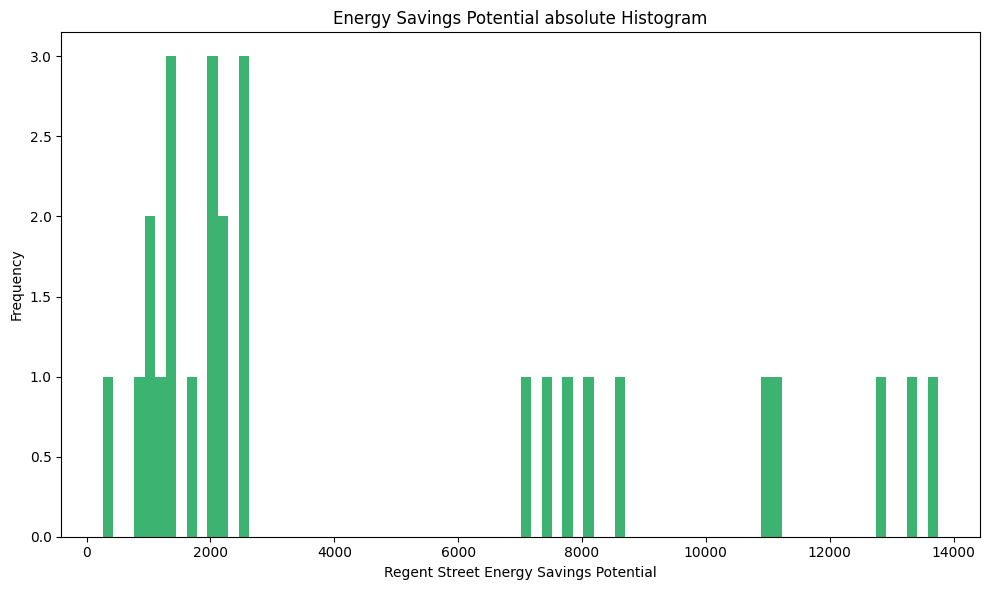

In [45]:
# plot histogram for absolute Regent Street Savings
regent_energy_savings = regent_savings_geospatial['energy_cost_savings']

# plot
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(regent_energy_savings, bins=80, color='mediumseagreen')  # Assuming you want to use 'mediumseagreen' color
plt.xlabel('Regent Street Energy Savings Potential')  # Replace with the appropriate x-axis label
plt.ylabel('Frequency')  # Replace with the appropriate y-axis label
plt.title('Energy Savings Potential absolute Histogram')  # Replace with the appropriate title
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

In [46]:
# calculate the septiles
septiles = np.percentile(regent_energy_savings, [14.2857, 28.5714, 42.8571, 57.1429, 71.4286, 85.7143])

print("Septiles:")
for i, septile in enumerate(septiles, start=1):
    print(f"Septile {i}: {septile}")

Septiles:
Septile 1: 1097.1191441300473
Septile 2: 1506.6990422835788
Septile 3: 2101.886536692721
Septile 4: 2529.4575487360776
Septile 5: 7634.234975767964
Septile 6: 10965.785764209118


In [66]:
# Creating a map with absolute savings for Regent Street Assets

def color_producer_regent_abs(val):
   '''Returns a colour for value range'''
   if val < 2000:
      return '#FFB6C1' # '#FFB6C1' (Light Pink)
   elif val < 4000:
      return '#FFC0CB' # '#FFC0CB' (Pink)
   elif val < 6000:
      return '#FF69B4' # '#FF69B4' (Hot Pink)
   elif val < 8000:
      return '#FF1493' # '#FF1493' (Deep Pink)
   elif val < 1000:
      return '#C71585' # '#C71585' (Medium Violet Red)
   elif val < 12000:
      return '#DB7093' # '#DB7093' (Pale Violet Red)
   else:
      return '#8B0000' # '#8B0000' (Dark Red)

# creates Regent Street map
m_3 = folium.Map(location=[51.5147,-0.1424], tiles='cartodbpositron', zoom_start=16)
# plot a marker circle using assigned colours
for i in range(0, len(regent_savings_geospatial)):
    color = color_producer_regent_abs(regent_savings_geospatial.iloc[i]['energy_cost_savings'])
    Circle(
        location=[regent_savings_geospatial.iloc[i]['Lat'], regent_savings_geospatial.iloc[i]['Long']],
        radius=10,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        weight=1,
    ).add_to(m_3)
m_3

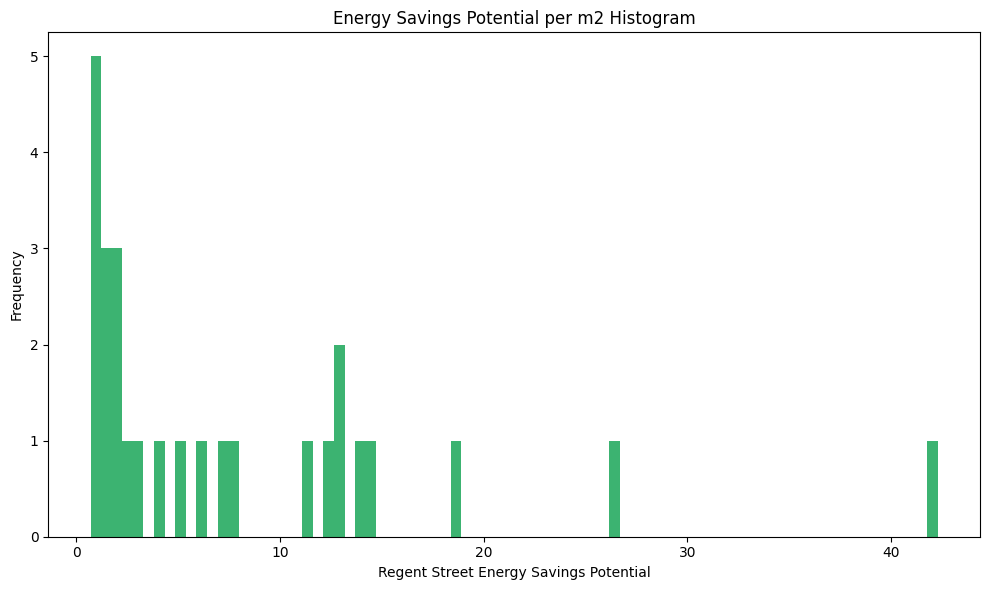

In [48]:
# plot histogram of Regent Street energy savings per m2
regent_energy_savings_per_m2 = regent_savings_geospatial['energy_cost_savings_per_m2']

# plot
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(regent_energy_savings_per_m2, bins=80, color='mediumseagreen')  # Assuming you want to use 'mediumseagreen' color
plt.xlabel('Regent Street Energy Savings Potential')  # Replace with the appropriate x-axis label
plt.ylabel('Frequency')  # Replace with the appropriate y-axis label
plt.title('Energy Savings Potential per m2 Histogram')  # Replace with the appropriate title
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

In [49]:
# calculate the septiles
septiles = np.percentile(regent_energy_savings_per_m2, [14.2857, 28.5714, 42.8571, 57.1429, 71.4286, 85.7143])

print("Septiles:")
for i, septile in enumerate(septiles, start=1):
    print(f"Septile {i}: {septile}")

Septiles:
Septile 1: 1.1072493790666966
Septile 2: 1.679963060519998
Septile 3: 2.5749619863758975
Septile 4: 6.184214422001007
Septile 5: 12.187628923619506
Septile 6: 14.290012054633204


In [51]:
# creating a map with Regent Street savings per m2

m_4 = folium.Map(location=[51.5147,-0.1424], tiles='cartodbpositron', zoom_start=16)
def color_producer_m2(val):
    '''Retruns a colour for the value range'''
    if val < 1.5:
        return '#ADD8E6'
    elif val < 3:
        return '#87CEEB'
    elif val < 5:
        return '#00BFFF'
    elif val < 7.5:
        return '#1E90FF'
    elif val < 10:
        return '#4169E1'
    elif val < 15:
        return '#0000CD'
    else:
        return '#00008B'

for i in range(0, len(regent_savings_geospatial)):
    color = color_producer_m2(regent_savings_geospatial.iloc[i]['energy_cost_savings_per_m2'])
    Circle(
        location=[regent_savings_geospatial.iloc[i]['Lat'], regent_savings_geospatial.iloc[i]['Long']],
        radius=10,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        weight=1,
    ).add_to(m_4)
m_4

In [78]:
# Find total savings potential
total_energy_savings = sum(regent_savings_geospatial['energy_cost_savings'])
postcode_with_max_savings = regent_savings_geospatial.loc[regent_savings_geospatial['energy_cost_savings'].idxmax(), 'postcode']
highest_savings = regent_savings_geospatial['energy_cost_savings'].max()

postcode_with_max_savings_per_m2 = regent_savings_geospatial.loc[regent_savings_geospatial['energy_cost_savings_per_m2'].idxmax(), 'postcode']
highest_savings_per_m2 = regent_savings_geospatial['energy_cost_savings_per_m2'].max()

postcode_with_max_emissions = regent_savings_geospatial.loc[regent_savings_geospatial['typical_emissions'].idxmax(), 'postcode']
highest_emissions = regent_savings_geospatial['typical_emissions'].max()

postcode_with_max_emissions_per_m2 = regent_savings_geospatial.loc[regent_savings_geospatial['emissions_per_m2'].idxmax(), 'postcode']
highest_emissions_per_m2 = regent_savings_geospatial['emissions_per_m2'].max()

print(f'Total energy savings for Regent Street is {total_energy_savings}')
print(f'The postcode with highest absolute potential savings is: location: {postcode_with_max_savings} with {highest_savings}')
print(f'The postcode with highest potential savings per m2 is: location: {postcode_with_max_savings_per_m2} with {highest_savings_per_m2}')
print(f'The postcode with highest absolute emissions is: location: {postcode_with_max_emissions} with {highest_emissions}')
print(f'The postcode with emissions per m2 is: location: {postcode_with_max_emissions_per_m2} with {highest_emissions_per_m2}')

Total energy savings for Regent Street is 128881.5847986869
The postcode with highest absolute potential savings is: location: w1b4hl with 13753.054429478043
The postcode with highest potential savings per m2 is: location: w1b4jd with 42.288569022919305
The postcode with highest absolute emissions is: location: w1b5rl with 104.88
The postcode with emissions per m2 is: location: w1b4jd with 0.31903973509933775


# Ideas for further improvements on this brief analysis

- **(1)** Making Choropleths for postcodes or districts
- **(2)** Standardize for listed buildings
- **(3)** Can you predict the energy savings potential from the area and the current_energy_ratings and area?
- **(4)** Given that London mixes domestic and non-domestic together and is a blended city, using domestic as a proxy could be justified
- **(5)** Retrofit costs, opportunity costs of energy savings and policy shock